In [152]:
import torch
import torch.nn as nn
from models import Flow, FlowKernel
from train_dynamics import load_model
from distributions import vf_lorenz
import matplotlib.pyplot as plt
from test_chaotic import get_stable_trajectory, load_lorenz

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# font size to 10
matplotlib.rcParams['font.size'] = 10

In [2]:
score_model, dataset = load_model('lorenz')

In [3]:
id = 61
v = FlowKernel(dim=dataset.dim)
v.load_state_dict(torch.load(f'./results/lorenz/models/dynamics_model_{id}.pth'))
v.eval().double()

FlowKernel(
  (nonlinear): SiLU()
  (mlp): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
    (5): VPJBatchNorm(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)

In [113]:
import torch

# Randomly sample 64 points from the time series
indices = torch.randperm(len(dataset.time_series))[:512]
x = dataset.time_series[indices].double()

# x, eps = score_model.diffuse(x, t=torch.ones(1) * 0.2)

In [119]:
v_lorenz = vf_lorenz(sigma=10.0, rho=28.0, beta=8.0/3.0)
dynamics_lorenz = []

for x_point in x:
    xt = dataset.denormalize(x_point)
    with torch.no_grad():
        delta = v_lorenz(xt) / dataset.std
    dynamics_lorenz.append(delta.reshape(-1))

dynamics_lorenz = torch.cat(dynamics_lorenz)
dynamics_lorenz = dynamics_lorenz.reshape(1, -1) / (dynamics_lorenz.norm() + 1e-9)

In [115]:
dynamics = []

for id in range(100):
    v = FlowKernel(dim=dataset.dim)
    v.load_state_dict(torch.load(f'./results/lorenz/models/dynamics_model_{id}.pth'))
    v.eval().double()
    xt = x
    with torch.no_grad():
        delta = v(xt)
    dynamics.append(delta.reshape(-1)) # [batch, 3]

dynamics = torch.stack(dynamics)
dynamics = dynamics / (dynamics.norm(dim=-1, keepdim=True) + 1e-9)

In [204]:
512*3

1536

In [ ]:
dynamics_random = []

for id in range(100):
    v = FlowKernel(dim=dataset.dim)
    v.eval().double()
    xt = x
    with torch.no_grad():
        delta = v(xt)
    dynamics_random.append(delta.reshape(-1)) # [batch, 3]

dynamics_random = torch.stack(dynamics_random)
dynamics_random = dynamics_random / (dynamics_random.norm(dim=-1, keepdim=True) + 1e-9)

In [160]:
def direction_align(v):
    sign = dynamics[..., :10].mean(dim=-1, keepdim=True).sign()
    return v * sign

In [197]:
BACKGROUND_COLOR = '#CECECE'
SUB_COLOR = '#9BE1E1'
HIGHLIGHT_COLOR = '#FEB400'
MAIN_COLOR = '#628FCE'

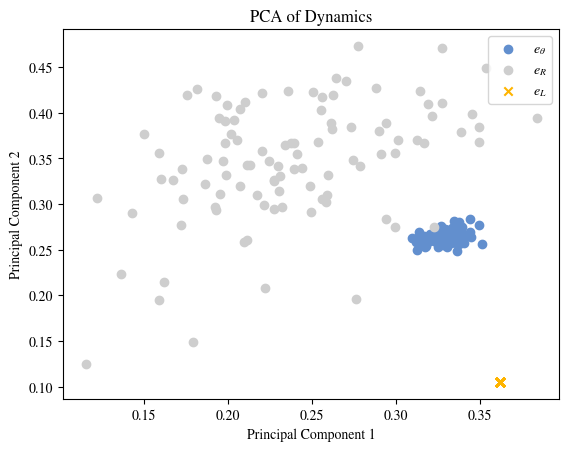

In [207]:
# Apply PCA on dynamics
from sklearn.decomposition import PCA

def plot_embedding(dynamics, dynamics_random, dynamics_lorenz, ax=None, alpha=1):
    if ax is None:
        ax = plt.gca()
    pca = PCA(n_components=2)
    _ = pca.fit_transform(torch.cat([
            direction_align(dynamics), 
            direction_align(dynamics_random), 
            direction_align(dynamics_lorenz)
        ], dim=0).numpy())
    dynamics_pca = pca.transform(direction_align(dynamics).abs())
    random_pca = pca.transform(direction_align(dynamics_random).abs())
    emb_lorenz = pca.transform(direction_align(dynamics_lorenz).abs())

    ax.scatter(dynamics_pca[:, 0], dynamics_pca[:, 1], color=MAIN_COLOR, label=r'$e_\theta$', alpha=alpha)
    ax.scatter(random_pca[:, 0], random_pca[:, 1], color=BACKGROUND_COLOR, label=f'$e_R$', alpha=alpha)
    ax.scatter(emb_lorenz[:, 0], emb_lorenz[:, 1], color=HIGHLIGHT_COLOR, marker='x', label=f'$e_L$')

plot_embedding(dynamics, dynamics_random, dynamics_lorenz)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dynamics')
plt.legend()
plt.show()

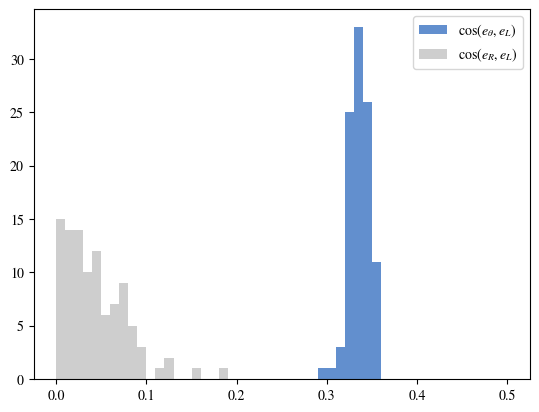

In [206]:
def plot_similarity(dynamics, dynamics_random, dynamics_lorenz, ax=None):

    if ax is None:
        ax = plt.gca()
    ax.hist(
        torch.einsum('nd, xd->n', dynamics, dynamics_lorenz).abs().numpy(), 
        density=True,
        label=r'$\cos(e_{\theta}, e_L)$',
        color=MAIN_COLOR,
        bins=50, range=(0, 0.5))
    ax.hist(
        torch.einsum('nd, xd->n', dynamics_random, dynamics_lorenz).abs().numpy(), 
        density=True,
        label=r'$\cos(e_R, e_L)$',
        color=BACKGROUND_COLOR,
        bins=50, range=(0, 0.5))

plot_similarity(dynamics, dynamics_random, dynamics_lorenz)
plt.legend()
plt.show()

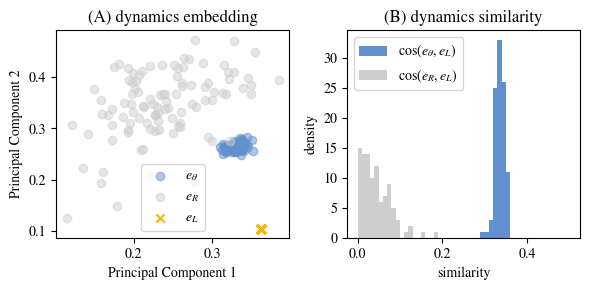

In [208]:
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plot_embedding(dynamics, dynamics_random, dynamics_lorenz, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('(A) dynamics embedding')
plt.legend()

plt.subplot(1,2,2)
plot_similarity(dynamics, dynamics_random, dynamics_lorenz)
plt.xlabel('similarity')
plt.ylabel('density')
plt.title('(B) dynamics similarity')
plt.legend()

plt.tight_layout()
plt.savefig('./results/lorenz/uniqueness.pdf', bbox_inches='tight')
plt.show()

In [374]:
import pickle

lyapunov = pickle.load(open('./results/lorenz/lyapunov_exponent.pkl', 'rb'))

In [97]:
from test_chaotic import get_stable_trajectory, load_lorenz

In [159]:
traj = get_stable_trajectory(v, 1)

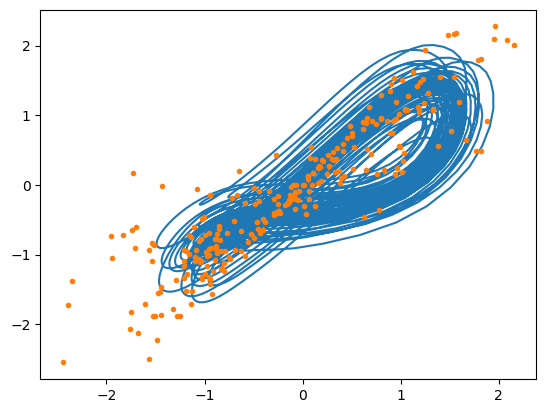

In [355]:
v = FlowKernel(dim=dataset.dim)
v.load_state_dict(torch.load(f'./results/lorenz/models/dynamics_model_{4}.pth'))
v.eval().double()
traj = get_stable_trajectory(v, 1)
plt.plot(traj[0][:, 0], traj[0][:, 1])
plt.plot(x[:, 0], x[:, 1], '.')
plt.show()

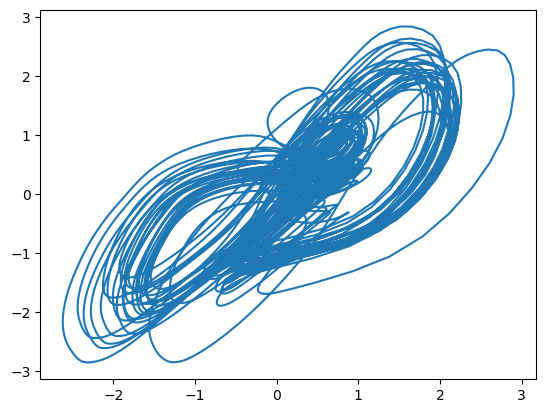

In [149]:
plt.plot(
    lyapunov['data'][61]['reference_trajs'][2, :, 0],
    lyapunov['data'][61]['reference_trajs'][2, :, 1])
plt.show()